In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [14]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [15]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,-24.943642,-14.376371,-30.270120,-34.804478,3.497355,8.651757
1,-41.976780,-51.831050,31.597225,0.572858,-34.029915,-22.983843
2,-10.403299,-20.507471,-35.264004,-31.831710,11.764874,-4.416489
3,-5.945934,22.957941,-33.201534,-32.098297,-3.378157,-19.997862
4,-14.173546,-47.217030,1.452709,18.719597,-17.833082,-30.701788


In [16]:
# min-max normalization
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [17]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.084583,0.175226,0.038894,0.000000,0.328542,0.372755,0.372755,5,Walking,Walking
1,0.051235,0.000000,0.433766,0.272462,0.092553,0.149984,0.433766,2,Sitting,Sitting
2,0.205586,0.122030,0.000000,0.028383,0.388906,0.255094,0.388906,4,Upstairs,Upstairs
3,0.213693,0.440310,0.000000,0.008650,0.233826,0.103521,0.440310,1,Jogging,Jogging
4,0.170724,0.000000,0.251459,0.340671,0.151817,0.085328,0.340671,3,Standing,Standing
5,0.197441,0.208309,0.053636,0.000000,0.171790,0.368823,0.368823,5,Walking,Walking
6,0.418554,0.076647,0.000000,0.052511,0.256686,0.195603,0.418554,0,Downstairs,Downstairs
7,0.440551,0.074178,0.000000,0.053104,0.211090,0.221078,0.440551,0,Downstairs,Downstairs
8,0.146728,0.511617,0.004771,0.030820,0.306064,0.000000,0.511617,1,Jogging,Jogging
9,0.142351,0.245095,0.042550,0.000000,0.201732,0.368272,0.368272,5,Walking,Walking


Accuracy:  0.9553235401238315


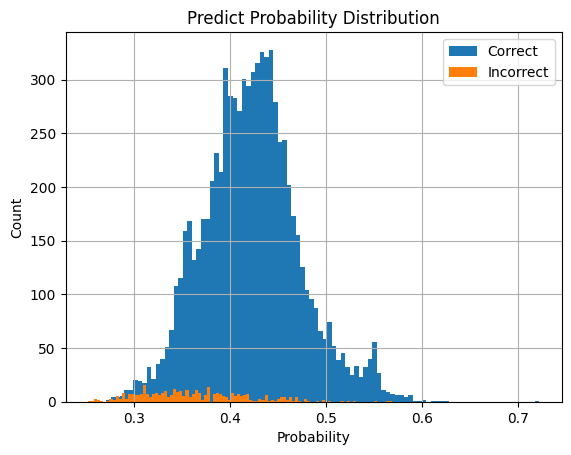

In [18]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [19]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.419786
std       0.052514
min       0.252540
max       0.721661
median    0.419969
Name: predict_probability, dtype: float64

In [20]:
thresholds = [0, 0.3, 0.35, 0.4, 0.5]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_df = pd.DataFrame(cm, index=LABELS, columns=LABELS)
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_16512/3327794854.py:2: RuntimeWarning: invalid value encountered in long_scalars
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.00,0.955324,1.000000,0.000000,0.000000
0.30,0.960599,0.989074,0.477778,0.010926
0.35,0.973807,0.913075,0.761173,0.086925
0.40,0.982358,0.653757,0.904278,0.346243
0.50,0.987478,0.067865,0.952983,0.932135
